In [ ]:
! pip install gradio

In [ ]:
!pip install --upgrade typing_extensions gradio altair


In [1]:
# Import libraries
import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import timeit
import cv2 as cv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix 

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model
from keras import backend as K
import kerastuner as kt
from keras.models import load_model

from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

import gradio as gr

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:21: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.


In [2]:
warnings.filterwarnings('ignore')

In [3]:
device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


### 1. Image Preprocessing
One of the required modules in this Notebook is to use transfer learning. A list of Keras applications and pretrained models is available at: https://keras.io/api/applications/.

First, we will select the model to use, since this will determine the image size to use (and therefore the resizing to perform). We will select a model that is:

Efficient (with good accuracy),

Of reasonable size for hardware and logistical reasons,

With medium depth so as not to overload computation times.

Based on these criteria, the Xception model seems suitable for our transfer learning: Size of 88 MB, Top-5 Accuracy of 0.945, and Depth of 126. The input images for this model will be 299px x 299px. We will also test a second architecture to compare the results obtained. We will test the ResNet50 architecture.

To start, we will quickly analyze the data by looking especially at the distribution of dog breeds in the images directory:

#### 1.1. Visualization of the list of breeds (classes) and an example of data.

In [4]:
# Define path to data
annotations_dir = '../input/stanford-dogs-dataset/annotations/Annotation' 
images_dir = '../input/stanford-dogs-dataset/images/Images'

In [5]:
# Count the number of classes (dogs breeds)
breed_list = os.listdir(images_dir)
print("Number of breeds in dataset:", (len(breed_list)))

Number of breeds in dataset: 120


There are 120 dog breeds present in our dataset, which means 120 classes for our classifier.
We will now count the number of images for each breed to check if the distribution is balanced across the classes:

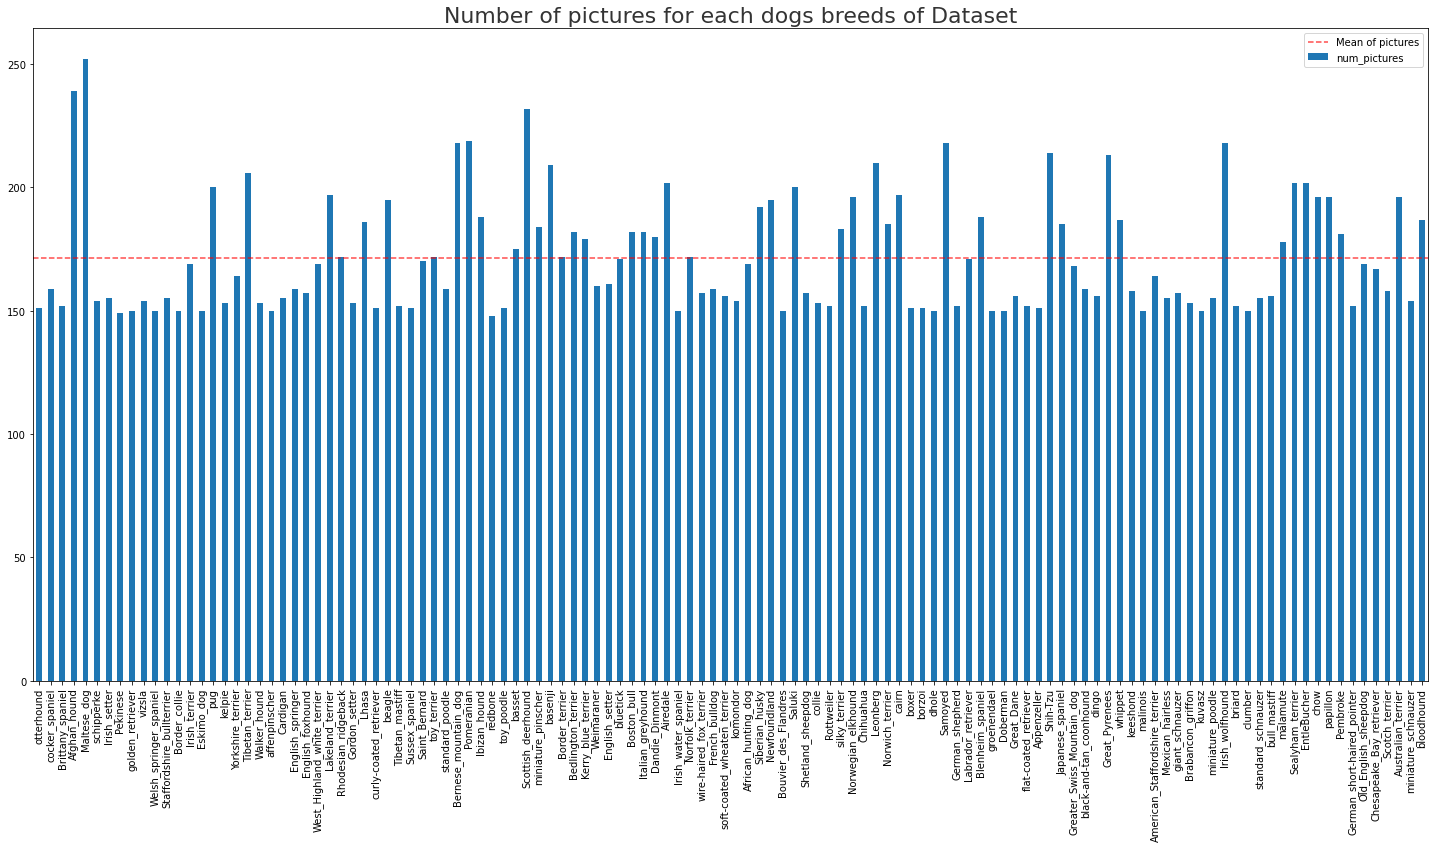

In [6]:
# Count number of pictures for each breed
df_breeds = pd.DataFrame(
    index=[breed.split('-',1)[1]
           for breed in breed_list],
    data=[len(os.listdir(images_dir + "/" + name))
          for name in breed_list],
    columns=["num_pictures"])

# Plot results
fig, ax = plt.subplots(1, 1, figsize=(25,12))
df_breeds.plot(kind="bar",
               legend=False,
               ax=ax)
ax.axhline(df_breeds["num_pictures"].mean(),
           color='r', alpha=.7,
           linestyle='--',
           label="Mean of pictures")
plt.title("Number of pictures for each "\
          "dogs breeds of Dataset",
          color="#343434", fontsize=22)
plt.legend()
plt.show()

In [7]:
def show_images_classes(path, classes, num_sample):
    """This function is used to display the first 
    n images of a directory passed as an argument. 
    It is adapted to subdirectories. 
    
    The matplotlib.image library must be loaded 
    with the alias mpimg. 

    Parameters
    ----------------------------------------
    path : string
        Link of root directory
    classes : string 
        Name of the subdirectory
    num_smaple : integer
        Number of picture to show
    ----------------------------------------
    """
    fig = plt.figure(figsize=(20,20))
    fig.patch.set_facecolor('#343434')
    plt.suptitle("{}".format(classes.split("-")[1]), y=.83,
                 color="white", fontsize=22)
    images = os.listdir(path + "/" + classes)[:num_sample]
    for i in range(num_sample):
        img = mpimg.imread(path+"/"+classes+"/"+images[i])
        plt.subplot(num_sample/5+1, 5, i+1)
        plt.imshow(img)
        plt.axis('off')
    plt.show()

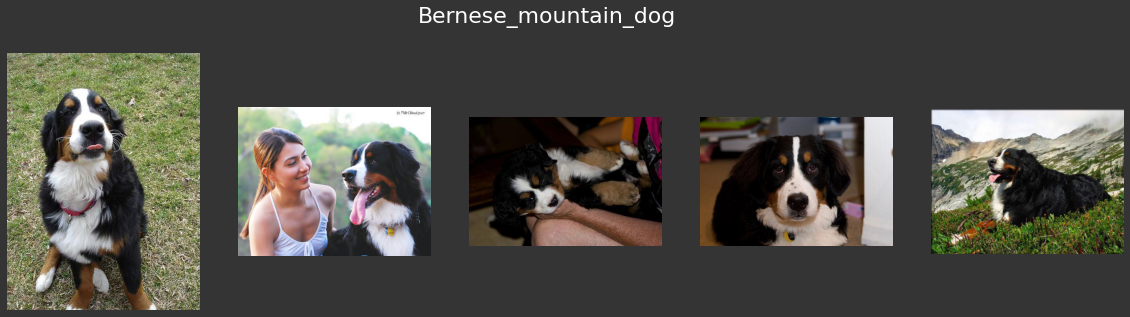

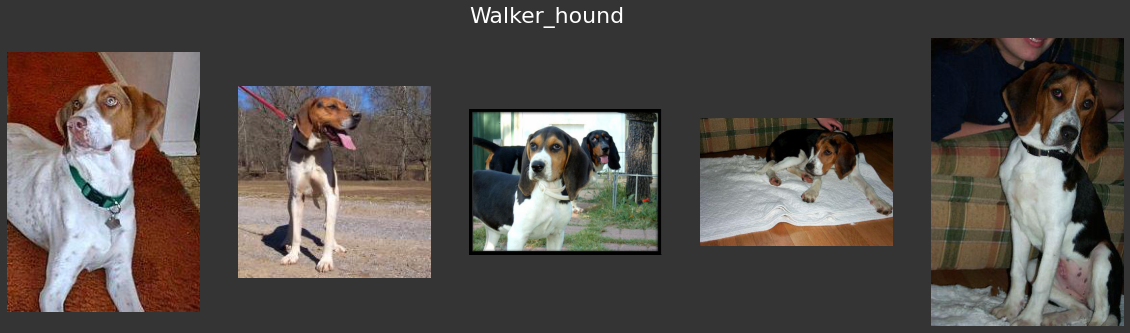

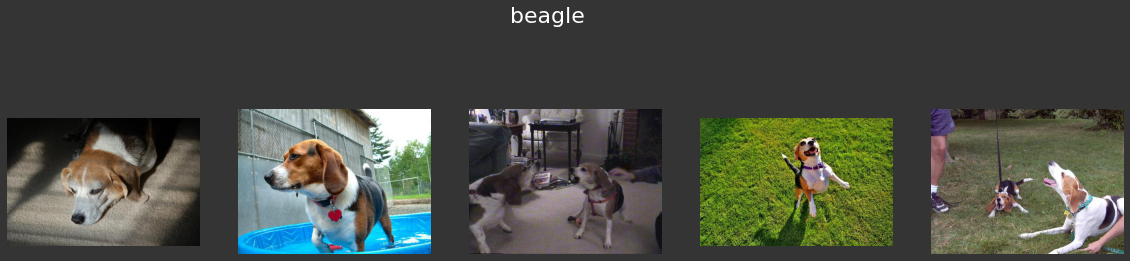

In [21]:
for i in np.random.randint(0, len(breed_list), size=3):
    show_images_classes(images_dir, breed_list[i], 5)

We will need to modify the size of the images so that they fit the constraints of the CNN transfer learning model. This will also help reduce the computation time compared to training a model from scratch.

#### 1.2. Changing the Image Size
We can notice in the example images above that the dogs are not always centered in the photo, and the zoom levels vary. Resizing the images will not change these attributes; in fact, the image may even be distorted to fit the new dimensions.

We will start by applying this transformation to a test image.

In [9]:
# Define test image
img_test = (images_dir 
            + "/" 
            + "n02085782-Japanese_spaniel/n02085782_1626.jpg")
img_test = cv.imread(img_test)

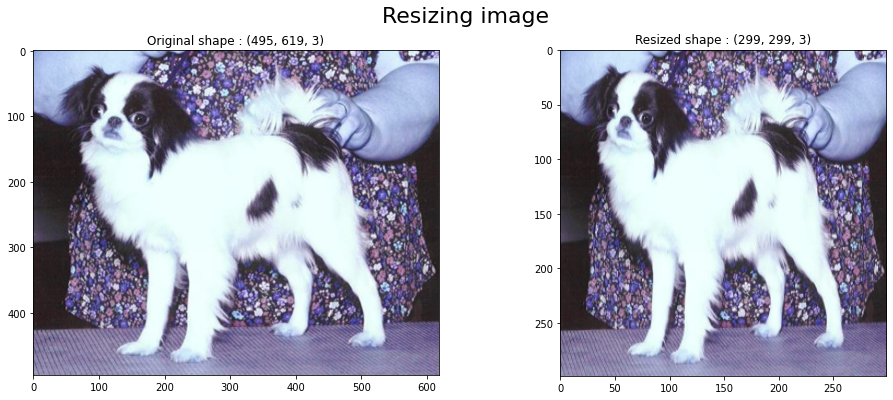

In [10]:
# setting dim of the resize
height = 299
width = 299
dim = (width, height)
# resize image with OpenCV
res_img = cv.resize(img_test, dim, interpolation=cv.INTER_LINEAR)

# Show both img
fig = plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.imshow(img_test)
plt.title("Original shape : {}".format(img_test.shape))
plt.subplot(1, 2, 2)
plt.imshow(res_img)
plt.title("Resized shape : {}".format(res_img.shape))
plt.suptitle("Resizing image",
             color="black", 
             fontsize=22, y=.98)
plt.show()

We can clearly see here that resizing to 299 x 299 distorts the original photo. Once this resizing is applied to all images, they will likely all be distorted.

Another point is that with a relatively large image set, the exposure, contrast, etc., vary considerably from photo to photo. We will now use methods based on the histograms of these images to better preprocess the data.

#### 1.3. Modification of Image Histograms
The histogram of a digital image is a statistical curve representing the distribution of its pixels according to their intensity. Let’s start by looking at a particular image.

We will transform the image into different color encodings. The YUV color system is created from an RGB source. It is encoded in three components: Y represents the luminance (brightness information), while the other two (U and V) represent chrominance (color information). This format allows us to better visualize the histogram across the three dimensions:

In [11]:
# Transform image with differents color sets
img_RGB = cv.cvtColor(img_test, cv.COLOR_BGR2RGB)
img_grayscale = cv.cvtColor(img_test, cv.COLOR_RGB2GRAY)
img_YUV = cv.cvtColor(img_test,cv.COLOR_BGR2YUV)

In [12]:
# Create histogram
def plot_histogram(init_img, convert_img):
    """Function allowing to display the initial
    and converted images according to a certain
    colorimetric format as well as the histogram
    of the latter. 

    Parameters
    -------------------------------------------
    init_img : list
        init_img[0] = Title of the init image
        init_img[1] = Init openCV image
    convert_img : list
        convert_img[0] = Title of the converted
        convert_img[1] = converted openCV image
    -------------------------------------------
    """
    hist, bins = np.histogram(
                    convert_img[1].flatten(),
                    256, [0,256])
    # Cumulative Distribution Function
    cdf = hist.cumsum()
    cdf_normalized = cdf * float(hist.max()) / cdf.max()

    # Plot histogram
    fig = plt.figure(figsize=(25,6))
    plt.subplot(1, 3, 1)
    plt.imshow(init_img[1])
    plt.title("{} Image".format(init_img[0]), 
              color="#343434")
    plt.subplot(1, 3, 2)
    plt.imshow(convert_img[1])
    plt.title("{} Image".format(convert_img[0]), 
              color="#343434")
    plt.subplot(1, 3, 3)
    plt.plot(cdf_normalized, 
             color='r', alpha=.7,
             linestyle='--')
    plt.hist(convert_img[1].flatten(),256,[0,256])
    plt.xlim([0,256])
    plt.legend(('cdf','histogram'), loc = 'upper left')
    plt.title("Histogram of convert image", color="#343434")
    plt.suptitle("Histogram and cumulative "\
                 "distribution for test image",
              color="black", fontsize=22, y=.98)
    plt.show()

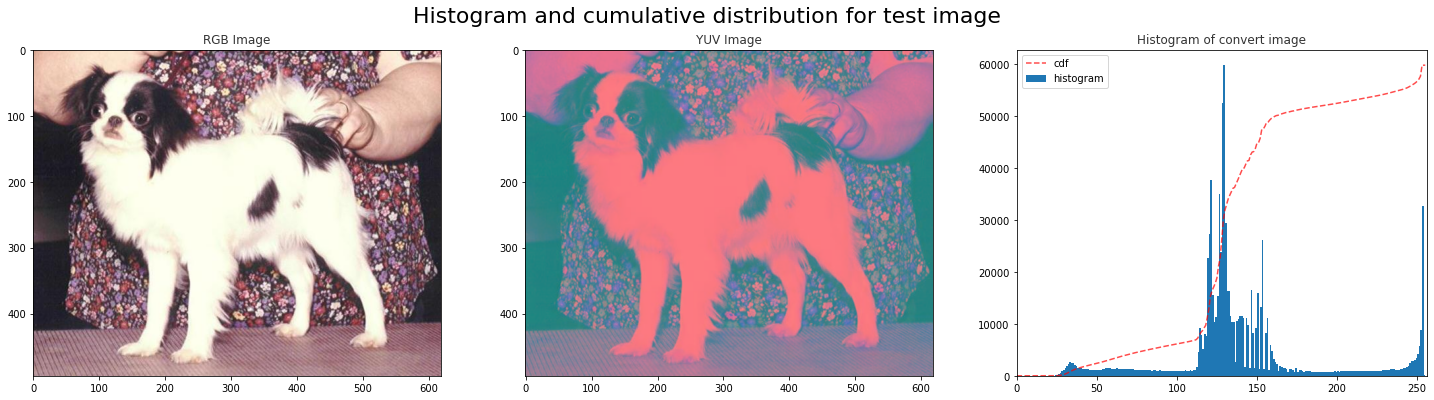

In [13]:
plot_histogram(["RGB", img_RGB], ["YUV", img_YUV])

### Equalization
We observe significant peaks in the center of the histogram. For good equalization (contrast enhancement), it is necessary to distribute the light evenly across the entire spectrum of the image.

Let’s test equalization with OpenCV:
The advantage of converting the image to the YUV color space is that we can act on the "luminance" channel (Y) independently from the other chrominance channels. We will therefore perform equalization on this Y channel only:

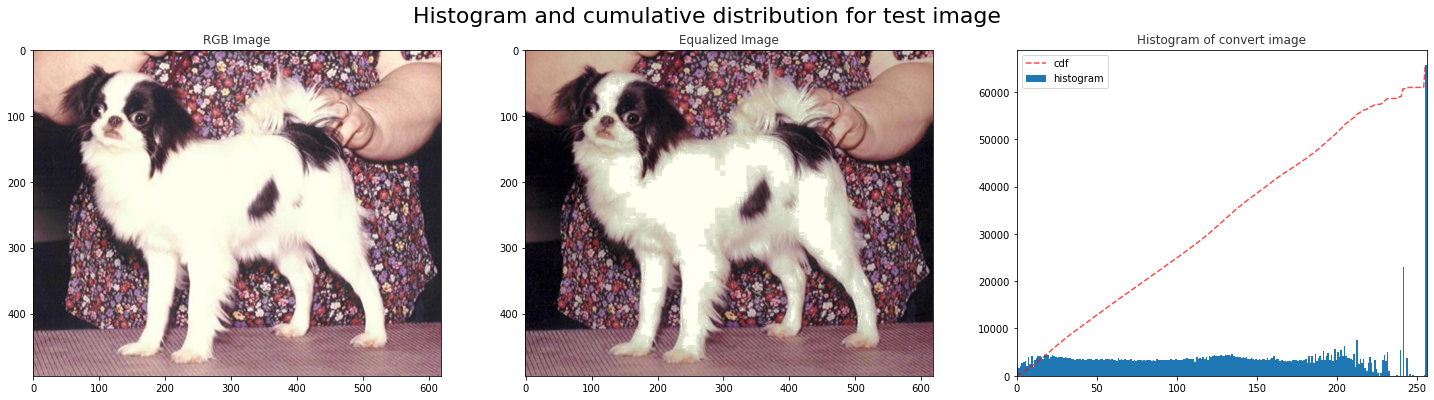

In [14]:
# Equalization
img_YUV[:,:,0] = cv.equalizeHist(img_YUV[:,:,0])
img_equ = cv.cvtColor(img_YUV, cv.COLOR_YUV2RGB)
plot_histogram(["RGB", img_RGB], ["Equalized", img_equ])

The resulting image is therefore well equalized; the histogram covers the entire spectrum and the CDF is constant and linear. This preprocessing will thus be applied to all images.

### 1.4. Application of Filters
Images can be noisy for many reasons, meaning they contain atypical pixels that can distort feature detection. Some causes of noise include:

Characteristics of the camera,

JPEG image compression,

Poor resolution, etc.

To reduce noise in images, filters can be applied. There are several types: linear filters (such as Gaussian filter), and non-linear filters like the median filter.
One of the best filters for denoising images is the non-local means filter.

#### Non-local Means Filter
Unlike “local averaging” filters, which take the average value of a group of pixels surrounding a target pixel to smooth the image, non-local means filtering takes an average of all pixels in the image, weighted by the similarity of these pixels to the target pixel. This results in much clearer post-filtering and less loss of detail in the image compared to local averaging algorithms.

Let’s test this filter on our test image:



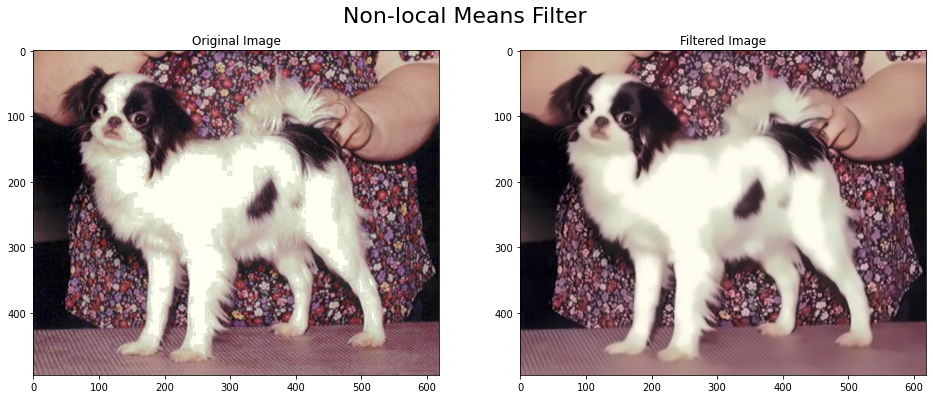

In [15]:
# Apply non-local means filter on test img
dst_img = cv.fastNlMeansDenoisingColored(
    src=img_equ,
    dst=None,
    h=10,
    hColor=10,
    templateWindowSize=7,
    searchWindowSize=21)

# Show both img
fig = plt.figure(figsize=(16,6))
plt.subplot(1, 2, 1)
plt.imshow(img_equ)
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(dst_img)
plt.title("Filtered Image")
plt.suptitle("Non-local Means Filter",
             color="black", 
             fontsize=22, y=.98)
plt.show()

### 1.5. Data Augmentation
The risk with this type of dataset, which contains relatively few images (20,000), is overfitting our model. It won’t be able to develop decision rules that generalize well to new data. Therefore, we need to increase the amount of data, and for this, we will use Data Augmentation.

The goal of data augmentation is to reproduce existing images by applying random transformations to them. To do this, Keras provides the ImageDataGenerator method, which allows you to perform random mirroring, rotation, zoom, and more!

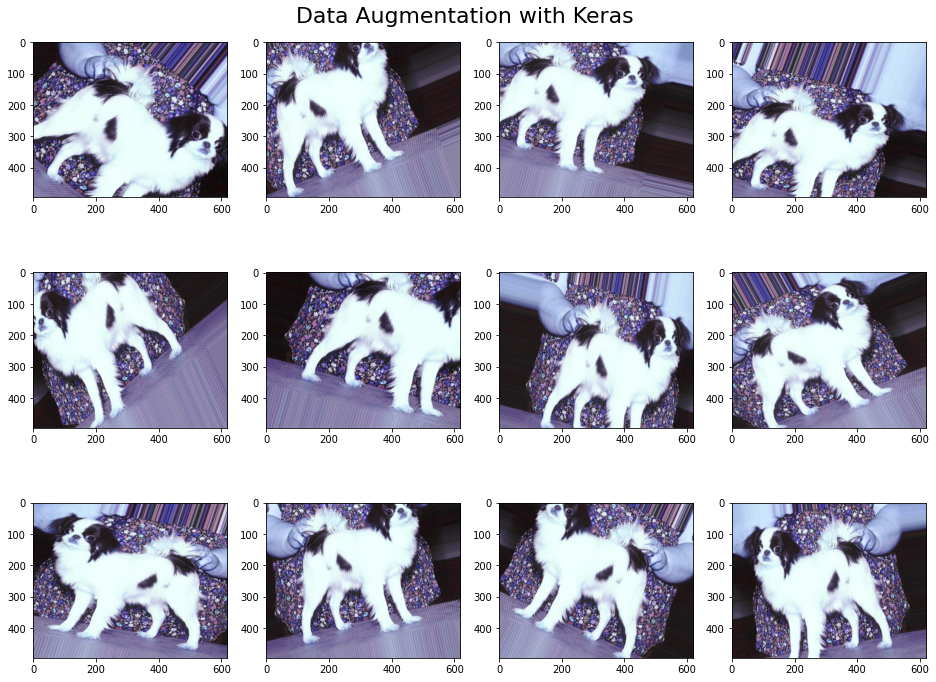

In [16]:
#Initilize Data Generator Keras
augmented_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest')

# Convert test img to array
x = image.img_to_array(img_test)
x = x.reshape((1,) + x.shape)

i=0
fig = plt.figure(figsize=(16,12))
for batch in augmented_datagen.flow(x, batch_size=1):
    ax = fig.add_subplot(3,4,i+1)
    ax.imshow(image.array_to_img(batch[0]))
    i += 1
    if i % 12 == 0:
        break

plt.suptitle("Data Augmentation with Keras",
             color="black", 
             fontsize=22, y=.90)
plt.show()


The Data Augmentation method allows us to obtain images with different zoom levels, mirror effects, and rotations, which will significantly and efficiently increase our image dataset.

### 1.6. Batch Processing Function for Preprocessing
We will first test the functions and classification on a limited number of dog breeds to reduce computation time. Let’s build the preprocessing function that will return the labels and images:

In [17]:
def preprocessing_cnn(directories, img_width, img_height):
    """Preprocessing of images in order to integrate them 
    into a convolutional neural network. Equalization, 
    Denoising and transformation of the image into Array. 
    Simultaneous creation of labels (y). 

    Parameters
    ---------------------------------------------------
    directoriesList : list
        List of files to be processed.
    img_width : integer
        width of the image to be reached for resizing
    img_height : integer
        height of the image to be reached for resizing
    ---------------------------------------------------
    """
    img_list=[]
    labels=[]
    for index, breed in enumerate(directories):
        for image_name in os.listdir(images_dir+"/"+breed):
            # Read image
            img = cv.imread(images_dir+"/"+breed+"/"+image_name)
            img = cv.cvtColor(img,cv.COLOR_BGR2RGB)
            # Resize image
            dim = (img_width, img_height)
            img = cv.resize(img, dim, interpolation=cv.INTER_LINEAR)
            # Equalization
            img_yuv = cv.cvtColor(img,cv.COLOR_BGR2YUV)
            img_yuv[:,:,0] = cv.equalizeHist(img_yuv[:,:,0])
            img_equ = cv.cvtColor(img_yuv, cv.COLOR_YUV2RGB)
            # Apply non-local means filter on test img
            dst_img = cv.fastNlMeansDenoisingColored(
                src=img_equ,
                dst=None,
                h=10,
                hColor=10,
                templateWindowSize=7,
                searchWindowSize=21)
            
            # Convert modified img to array
            img_array = image.img_to_array(dst_img)
            
            # Append lists of labels and images
            img_list.append(np.array(img_array))
            labels.append(breed.split("-")[1])
    
    return img_list, labels

We will create and train models on 15 of the 20 most popular dog breeds in France in 2020, according to the study from centrale-canine.fr. This algorithm can later be extended to include all breeds if it proves satisfactory.

In [18]:
fr_breed_list = [
    'n02096294-Australian_terrier',
    'n02093256-Staffordshire_bullterrier',
    'n02099601-golden_retriever',
    'n02106662-German_shepherd',
    'n02086240-Shih-Tzu',
    'n02099712-Labrador_retriever',
    'n02088364-beagle',
    'n02100735-English_setter',
    'n02102318-cocker_spaniel',
    'n02108915-French_bulldog',
    'n02094433-Yorkshire_terrier',
    'n02085620-Chihuahua',
    'n02110185-Siberian_husky',
    'n02106166-Border_collie',
    'n02106550-Rottweiler']

In [19]:
# Define numbers of breeds to preprocess
num_breeds = len(fr_breed_list) 

# Execute preprocessor on selection
start_time = timeit.default_timer()
# X = images
# y = labels
X, y = preprocessing_cnn(fr_breed_list, 299, 299)
# Convert in numpy array
X = np.array(X)
y = np.array(y)
preprocess_time = timeit.default_timer() - start_time
print("-" * 50)
print("Execution time for preprocessing :")
print("-" * 50)
print("Number of images preprocessed : {}"\
     .format(len(y)))
print("Shape of images np.array : {}"\
     .format(X.shape))
print("Total time : {:.2f}s".format(preprocess_time))

--------------------------------------------------
Execution time for preprocessing :
--------------------------------------------------
Number of images preprocessed : 2522
Shape of images np.array : (2522, 299, 299, 3)
Total time : 646.15s


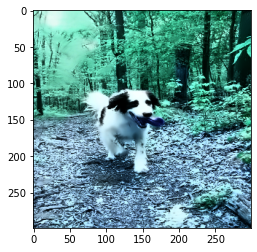

In [20]:
# Show exemple preprocessed image
plt.imshow(image.array_to_img(X[1234]))

### 2. CNN Model from Scratch
So far, our test images have been preprocessed using equalization, denoising, and resizing. We have created lists of Numpy arrays grouping the images in numerical format.
To train our first model, we must first shuffle the images, because currently all photos of the same breed are grouped together.

#### 2.1. Preparing Data for the CNN Model
We will shuffle the data in X and y before the first pass through the network. This shuffling aims to reduce variance and ensure the models do not overfit.

In [22]:
# Using np.shuffle
img_space = np.arange(X.shape[0])
np.random.seed(8)
# Shuffle the space
np.random.shuffle(img_space)
# Apply to X and y in same order
X = X[img_space]
y = y[img_space]

The images are now shuffled. For Keras modeling, we also need to modify the data types of our X data and convert our target data (y) into numeric variables. Currently, y contains textual data. We will use a simple LabelEncoder to convert them.

In [23]:
# Change X type 
X = X.astype(np.float32)
# Encode y text data in numeric
encoder = LabelEncoder()
encoder.fit(y)
y = encoder.transform(y)

In [24]:
# Verifie encoder created classes
print(encoder.classes_)

['Australian_terrier' 'Border_collie' 'Chihuahua' 'English_setter'
 'French_bulldog' 'German_shepherd' 'Labrador_retriever' 'Rottweiler'
 'Shih' 'Siberian_husky' 'Staffordshire_bullterrier' 'Yorkshire_terrier'
 'beagle' 'cocker_spaniel' 'golden_retriever']


Now, we can create the training and test sets that will be used to train our models. The validation set will be created directly within the Keras generator.

In [25]:
### Create train and test set
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

print("-" * 50)
print("Size of created sets :")
print("-" * 50)
print("Train set size = ",x_train.shape[0])
print("Test set size = ",x_test.shape[0])

--------------------------------------------------
Size of created sets :
--------------------------------------------------
Train set size =  2017
Test set size =  505


In [26]:
# Data generator on train set with Data Augmentation
# Validation set is define here
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

#For validation and test, just rescale
test_datagen = ImageDataGenerator(rescale=1./255)

These generators will be used in the Keras modeling pipelines.

#### 2.2. Building the CNN Model
Here, we will initialize a first convolutional neural network model by stacking several layers:

Convolutional Layers: Their purpose is to detect the presence of a set of features in the input images by applying convolutional filtering.

Pooling Layers: Pooling reduces the size of the images while preserving important features.

ReLU Activation Layers: The ReLU layer replaces all negative input values with zeros. It acts as the activation function.

Fully Connected Layers: These layers take a vector as input and produce a new output vector by applying a linear combination followed by an activation function if any.

Dropout: Dropout randomly "deactivates" neuron outputs to prevent overfitting.

For our model, we will test a simple, not-too-deep architecture to serve as a baseline for future models. Thus, we will implement only 3 convolutional layers.

We will also define metrics more precise than Accuracy for evaluating our model, such as the F1 Score, which combines precision and recall:

In [27]:
def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

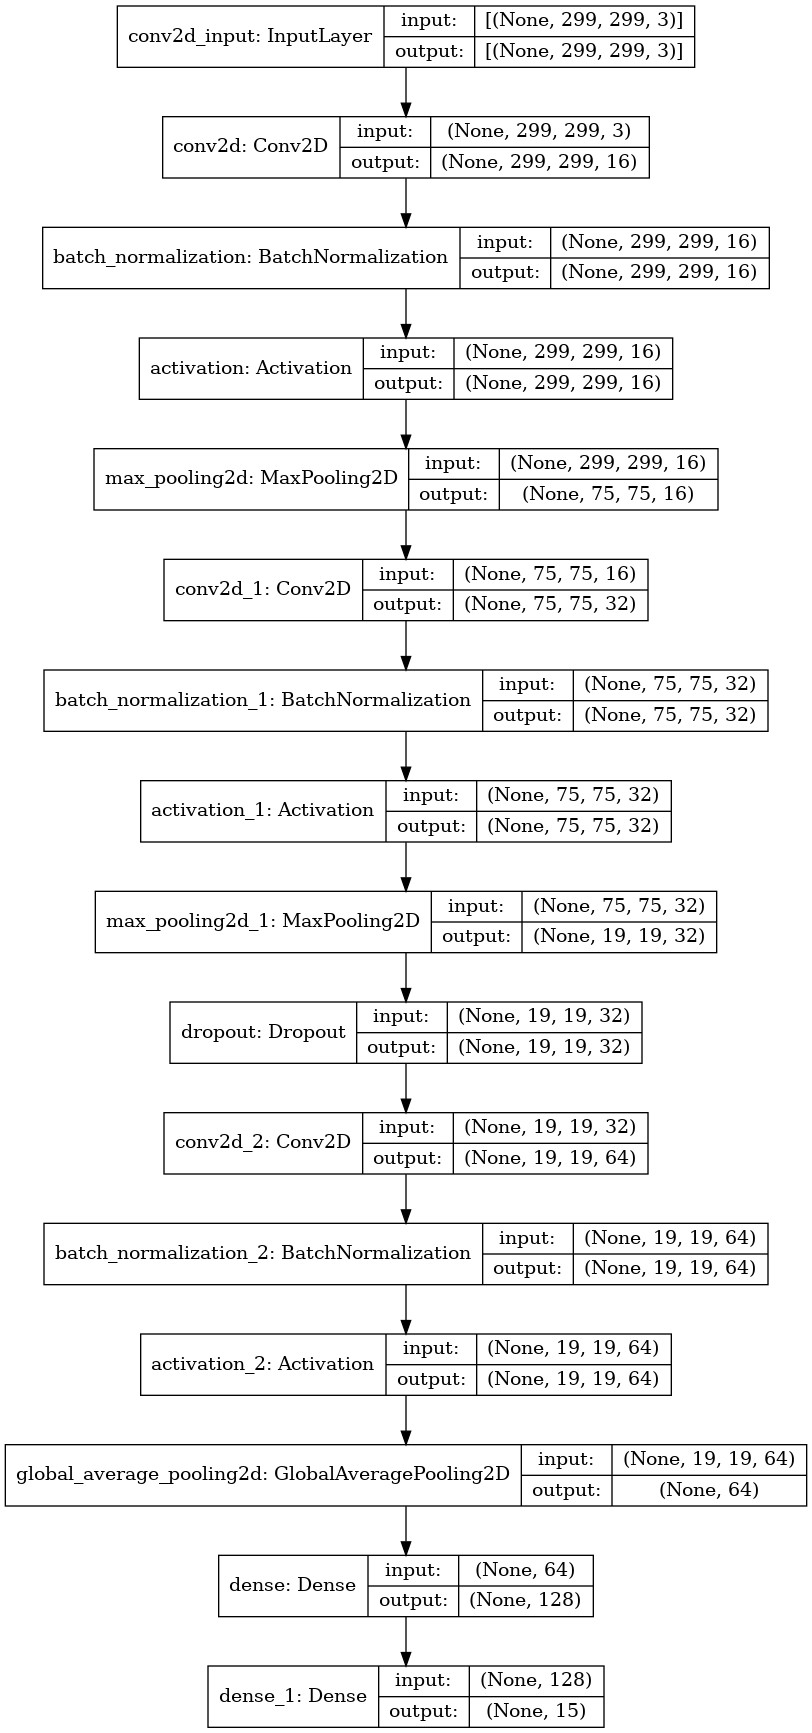

In [28]:
K.clear_session()
model = Sequential()
# Convolution layer
model.add(Conv2D(filters=16,
                 kernel_size=(3,3), 
                 padding='same',
                 use_bias=False,
                 input_shape=(299,299,3)))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation('relu'))
# Pooling layer
model.add(MaxPooling2D(pool_size=(4, 4),
                       strides=(4, 4),
                       padding='same'))
# Second convolution layer
model.add(Conv2D(filters=32,
                 kernel_size=(3,3), 
                 padding='same',
                 use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))
# Third convolution layer
model.add(Conv2D(filters=64,
                 kernel_size=(3,3), 
                 padding='same',
                 use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation('relu'))
model.add(GlobalAveragePooling2D())
# Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(num_breeds, activation='softmax'))
plot_model(model, to_file='CNN_model_plot.png', 
           show_shapes=True, show_layer_names=True)

In [29]:
# Compile the CNN Model
model.compile(optimizer="adam",
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy", f1_m])

Our model is created; we will now be able to train it over 50 epochs using the previously created generators and store the results for later analysis:

### 2.3. Training and Evaluation of the CNN Model

In [30]:
history = model.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    steps_per_epoch=len(x_train) / 32,
    epochs=20,
    verbose=2)

Epoch 1/20
63/63 - 33s - loss: 2.7217 - accuracy: 0.1045 - f1_m: 14.2324 - val_loss: 2.6965 - val_accuracy: 0.0868 - val_f1_m: 13.9889
Epoch 2/20
63/63 - 25s - loss: 2.6541 - accuracy: 0.1045 - f1_m: 14.1444 - val_loss: 2.7378 - val_accuracy: 0.0968 - val_f1_m: 11.9048
Epoch 3/20
63/63 - 24s - loss: 2.6471 - accuracy: 0.1096 - f1_m: 13.3382 - val_loss: 2.7681 - val_accuracy: 0.0868 - val_f1_m: 11.3401
Epoch 4/20
63/63 - 24s - loss: 2.6234 - accuracy: 0.1184 - f1_m: 12.6775 - val_loss: 2.6643 - val_accuracy: 0.0844 - val_f1_m: 13.4396
Epoch 5/20
63/63 - 24s - loss: 2.5803 - accuracy: 0.1367 - f1_m: 13.0886 - val_loss: 2.6747 - val_accuracy: 0.1216 - val_f1_m: 12.1405
Epoch 6/20
63/63 - 24s - loss: 2.5999 - accuracy: 0.1309 - f1_m: 12.3905 - val_loss: 2.6466 - val_accuracy: 0.0744 - val_f1_m: 12.3568
Epoch 7/20
63/63 - 24s - loss: 2.5732 - accuracy: 0.1436 - f1_m: 13.0757 - val_loss: 2.5847 - val_accuracy: 0.1315 - val_f1_m: 12.3176
Epoch 8/20
63/63 - 24s - loss: 2.5663 - accuracy: 0.136

In [31]:
def plot_history_scores(dict_history, first_score, second_score):
    with plt.style.context('seaborn-whitegrid'):
        fig = plt.figure(figsize=(25,10))
        # summarize history for accuracy
        plt.subplot(1, 2, 1)
        plt.plot(dict_history.history[first_score], color="g")
        plt.plot(dict_history.history['val_' + first_score],
                 linestyle='--', color="orange")
        plt.title('CNN model ' + first_score, fontsize=18)
        plt.ylabel(first_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        # summarize history for loss
        plt.subplot(1, 2, 2)
        plt.plot(dict_history.history[second_score], color="g")
        plt.plot(dict_history.history['val_' + second_score],
                 linestyle='--', color="orange")
        plt.title('CNN model ' + second_score, fontsize=18)
        plt.ylabel(second_score)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()

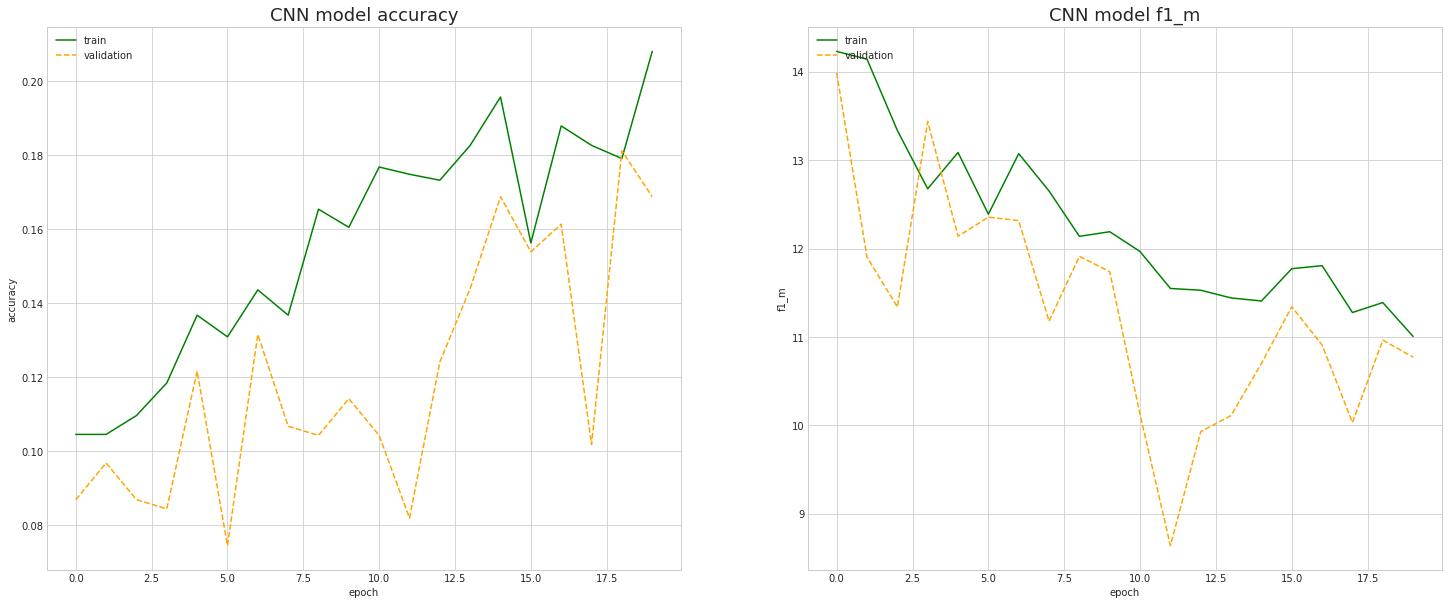

In [32]:
plot_history_scores(
    dict_history = history, 
    first_score = "accuracy", 
    second_score = "f1_m")

We see that with this CNN model trained from scratch, the metrics are not good. The accuracy does not exceed 13%, and the F1 score remains high and stable over the 50 epochs.

We will now test pre-trained models and check if the performance improves compared to our baseline.

### 3. Transfer Learning: Pre-trained CNN Model Xception
The Xception model is derived from the Inception architecture. Inception aims to reduce the resource consumption of deep CNNs. It relies on the use of the following processing blocks:
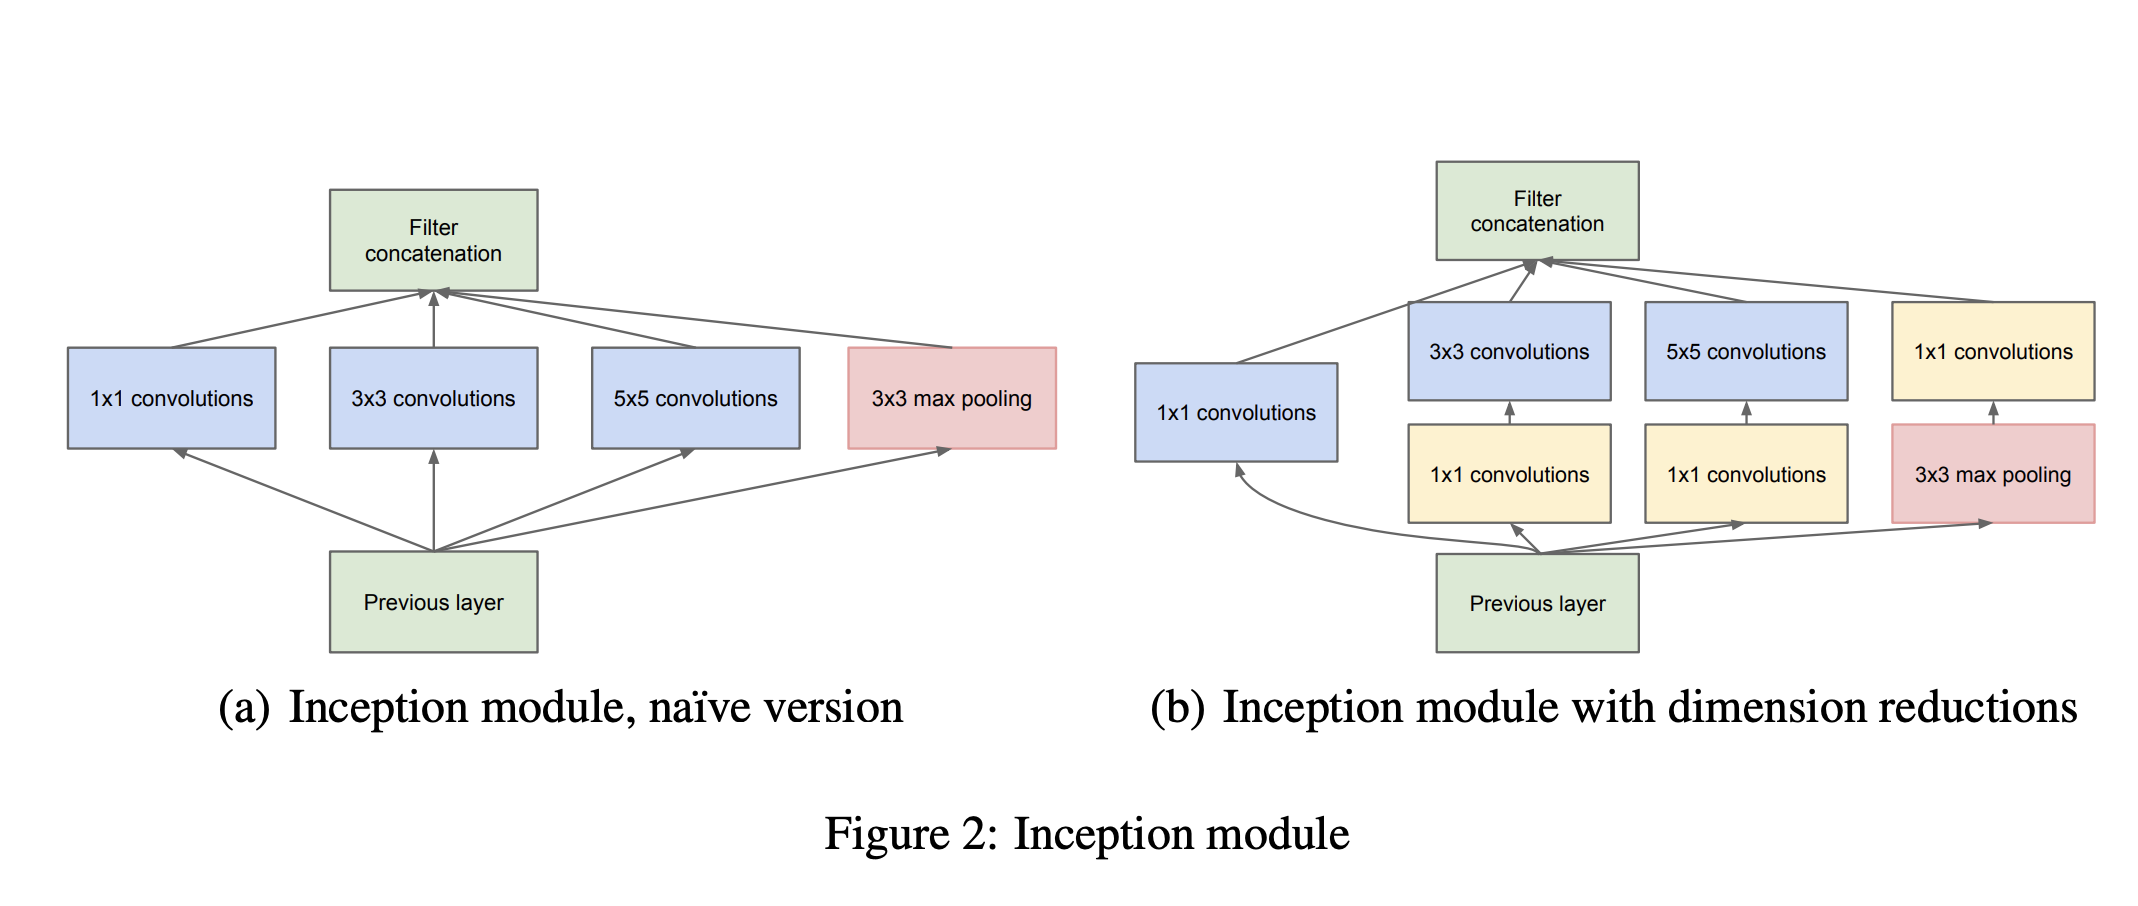

The image dimension is reduced by the 3x3 and 5x5 filters, adding a 1x1 filtering step upstream. This way, the 1x1 convolution performs a pooling operation on pixel values in the image’s dimension space.
Xception replaces the Inception modules with depthwise separable convolution modules and adds residual connections. This approach significantly reduces resource usage during matrix computation without changing the number of parameters.
To learn more: https://arxiv.org/abs/1610.02357

The Xception architecture is as follows:
![inception_block](http://www.mf-data-science.fr/images/projects/imagenet_xception_flow.png)


#### 3.1. Importing the pre-trained Xception model
Let’s load the base pre-trained Keras model without the fully connected layers. We will add our own final classifier.


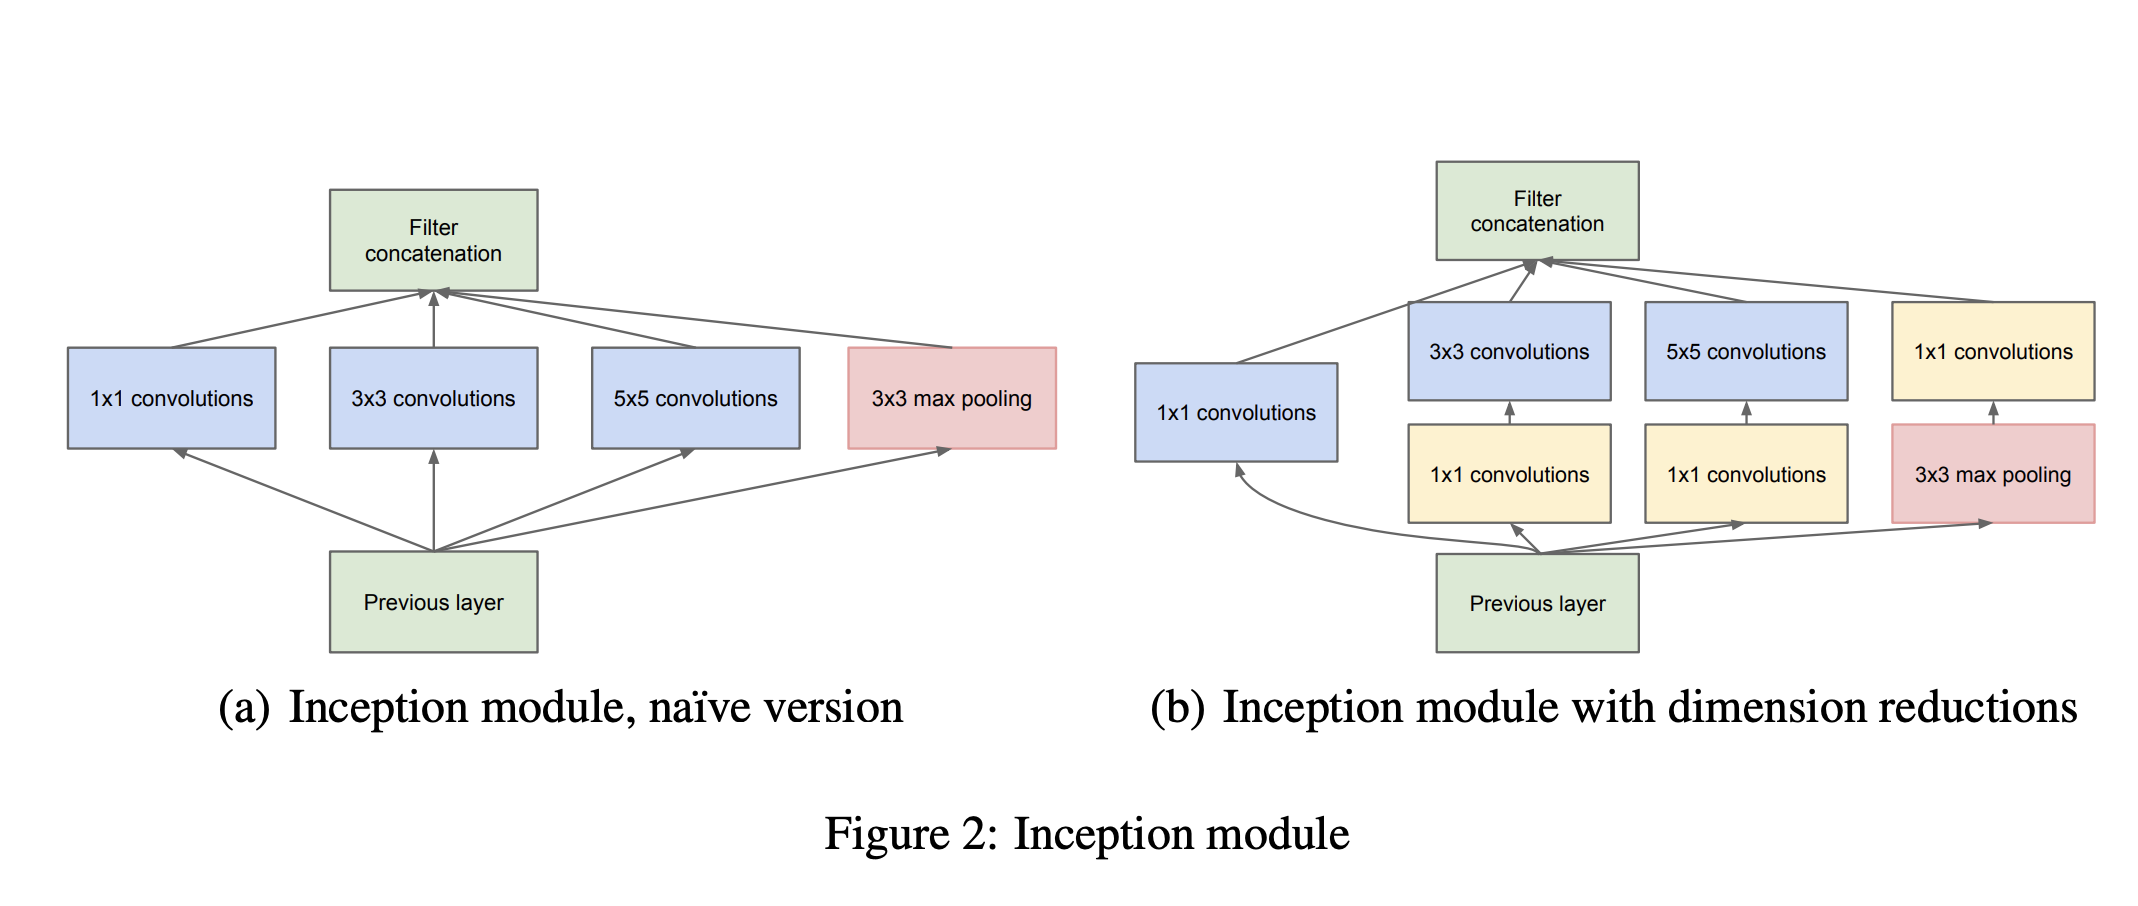

In [33]:
K.clear_session()
# Import Xception trained model
xception_model = tf.keras.applications.xception.Xception(
    weights='imagenet',
    include_top=False, 
    pooling='avg',
    input_shape=(299,299,3))

# look at the differents layers
print("-" * 50)
print("Xception base model layers :")
print("-" * 50)
for layer in xception_model.layers:
    print(layer)

83689472/83683744 [==============================] - 0s 0us/step
--------------------------------------------------
Xception base model layers :
--------------------------------------------------


### 3.2. Training the new classifier on Xception
Our dataset is small and relatively similar to the original dataset used to train Xception. If we train the entire network, we risk overfitting. Therefore, we will “freeze” all the layers of Xception and only train the classifier.

In [35]:
for layer in xception_model.layers:
    layer.trainable = False

We observe in the imported layers of the model that the last imported layer is a GlobalAveragePooling2D layer.
Therefore, we will add a fully connected layer, followed by a Dropout layer, and finally the classifier layer to create our new model.

In [36]:
# Add new fully-connected layers
base_output = xception_model.output
base_output = Dense(128, activation='relu')(base_output)
base_output = Dropout(0.2)(base_output)
# Output : new classifier
predictions = Dense(num_breeds, activation='softmax')(base_output)

# Define new model
my_xcept_model = Model(inputs=xception_model.input,
                       outputs=predictions)
my_xcept_model.compile(optimizer="adam",
                       loss="sparse_categorical_crossentropy",
                       metrics=["accuracy", f1_m])

In [37]:
Xception_plot = plot_model(my_xcept_model,
                           to_file='xcept_model_plot.png',
                           show_shapes=True,
                           show_layer_names=False)

In [38]:
# Data generator on train set with Data Augmentation
# and preprocess_input Xception
# Validation set is define here
train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.xception.preprocess_input)

#For validation and test, just rescale
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.xception.preprocess_input)

In [39]:
history_xcept = my_xcept_model.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    steps_per_epoch=len(x_train) / 32,
    epochs=20,
    verbose=2)

Epoch 1/20
63/63 - 29s - loss: 1.6633 - accuracy: 0.5147 - f1_m: 7.0408 - val_loss: 0.9401 - val_accuracy: 0.7047 - val_f1_m: 3.3348
Epoch 2/20
63/63 - 25s - loss: 0.9372 - accuracy: 0.7016 - f1_m: 2.8775 - val_loss: 0.8058 - val_accuracy: 0.7568 - val_f1_m: 2.5751
Epoch 3/20
63/63 - 25s - loss: 0.8257 - accuracy: 0.7211 - f1_m: 2.5132 - val_loss: 0.7087 - val_accuracy: 0.7494 - val_f1_m: 2.3077
Epoch 4/20
63/63 - 25s - loss: 0.6923 - accuracy: 0.7691 - f1_m: 2.2060 - val_loss: 0.7209 - val_accuracy: 0.7494 - val_f1_m: 2.3682
Epoch 5/20
63/63 - 25s - loss: 0.6813 - accuracy: 0.7847 - f1_m: 2.1923 - val_loss: 0.7077 - val_accuracy: 0.7593 - val_f1_m: 2.0317
Epoch 6/20
63/63 - 25s - loss: 0.6554 - accuracy: 0.7808 - f1_m: 2.1325 - val_loss: 0.7323 - val_accuracy: 0.7643 - val_f1_m: 1.9787
Epoch 7/20
63/63 - 25s - loss: 0.6550 - accuracy: 0.7812 - f1_m: 2.0194 - val_loss: 0.6703 - val_accuracy: 0.7742 - val_f1_m: 1.9976
Epoch 8/20
63/63 - 25s - loss: 0.5956 - accuracy: 0.8023 - f1_m: 2.06

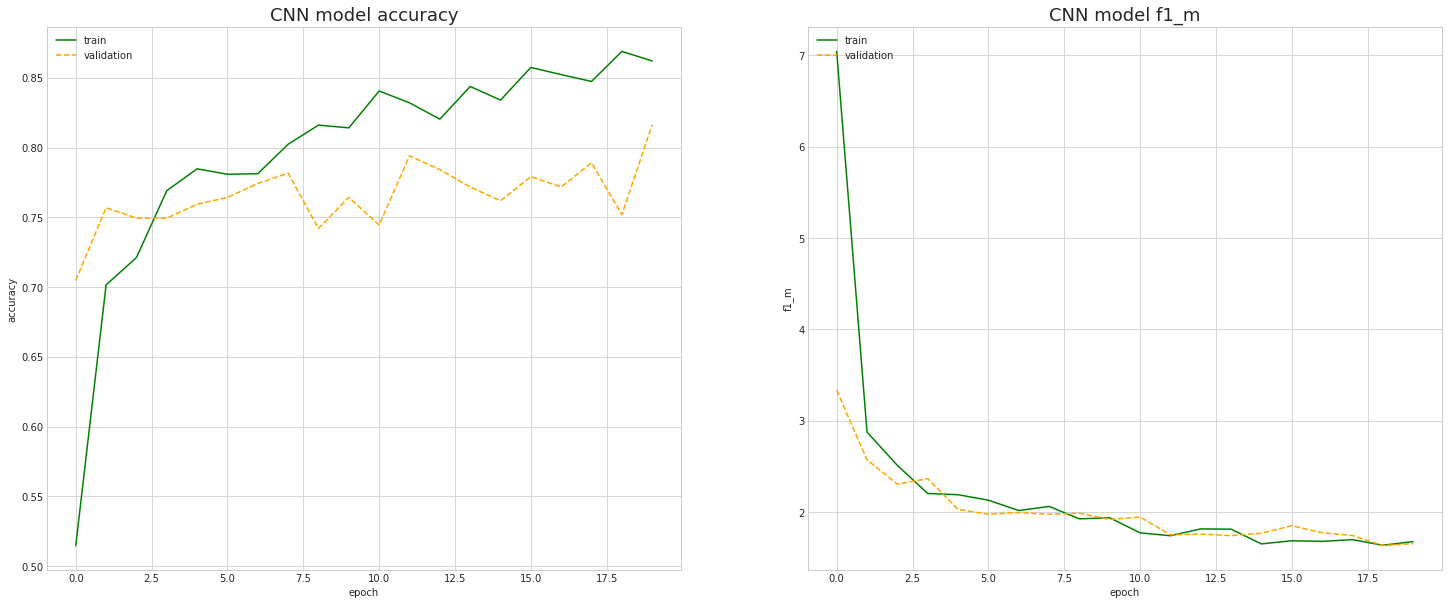

In [40]:
plot_history_scores(
    dict_history = history_xcept, 
    first_score = "accuracy", 
    second_score = "f1_m")

We can clearly see that the metrics of the Xception model on our data are much better than those of the “from scratch” model when the deep layers are frozen (not trained).
Moreover, the model learns very quickly — accuracy increases rapidly while the loss decreases.
Let’s compare the two models:

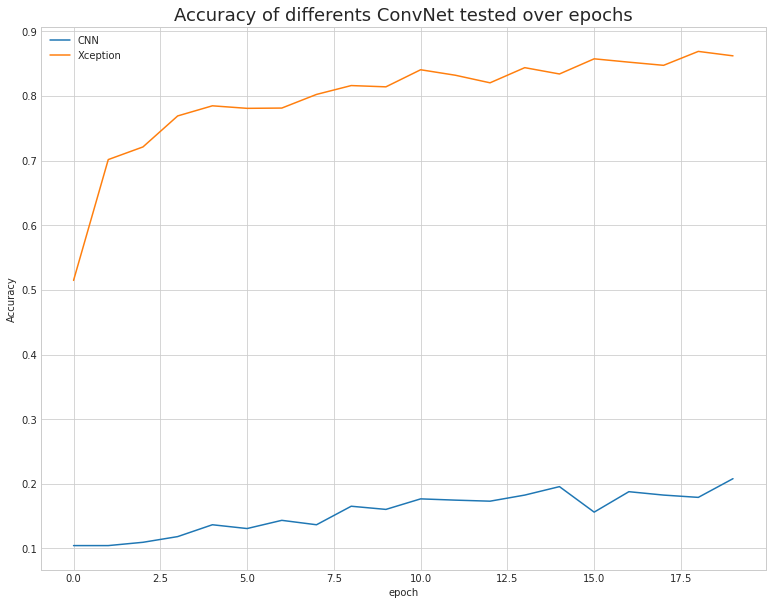

In [41]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(13,10))
    plt.plot(history.history['accuracy'],
             label='CNN')
    plt.plot(history_xcept.history['accuracy'],
             label='Xception')
    plt.title('Accuracy of differents ConvNet tested over epochs',
              fontsize=18)
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

In [42]:
xcept_mean_accuracy = np.mean(history_xcept.history['val_accuracy'])
xcept_mean_f1 = np.mean(history_xcept.history['val_f1_m'])
print("-" * 50)
print("Xception base model validation Scores :")
print("-" * 50)
print("Mean validation accuracy: {:.2f}"\
      .format(xcept_mean_accuracy))
print("Mean validation F1 score: {:.2f}"\
      .format(xcept_mean_f1))

--------------------------------------------------
Xception base model validation Scores :
--------------------------------------------------
Mean validation accuracy: 0.77
Mean validation F1 score: 2.01


### 3.3. Comparison with the ResNet50 Model Architecture
In a deep convolutional neural network, multiple layers are stacked and trained to perform a specific task. The network learns features at low, mid, and high levels by the end of its layers.

In residual learning, instead of learning certain features directly, the network learns residual features — the residual can be simply understood as the difference between a feature and the input to that layer.

ResNet achieves this by using shortcut connections that directly link the input of the nth layer to a later (n+x)th layer. Its architecture looks like this:
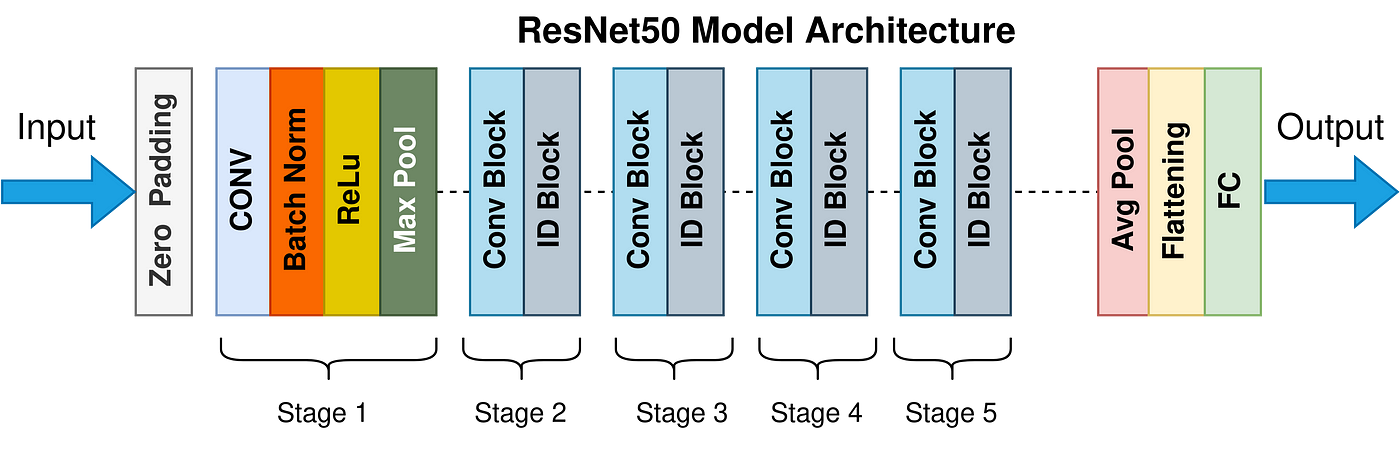

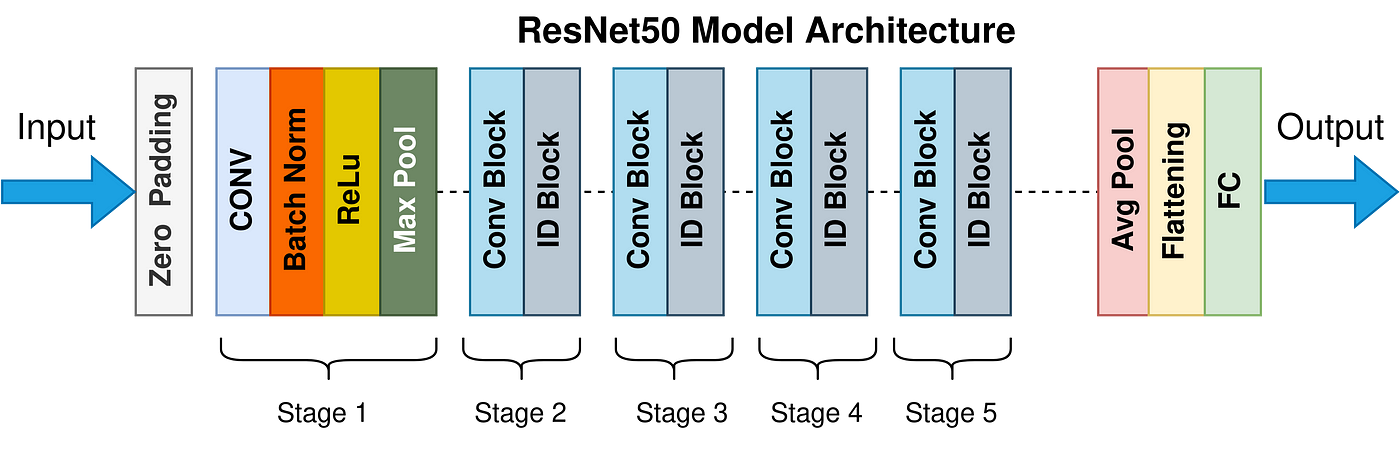

In [43]:
 K.clear_session()
# Import ResNet50 trained model
resnet_model = tf.keras.applications.ResNet50(
    weights='imagenet',
    include_top=False, 
    pooling='avg',
    input_shape=(299,299,3))

# Dont retrain layers
for rn_layer in resnet_model.layers:
    rn_layer.trainable = False
    
# Add new fully-connected layers
rn_base_output = resnet_model.output
rn_base_output = Dense(128, activation='relu')(rn_base_output)
rn_base_output = Dropout(0.2)(rn_base_output)
# Output : new classifier
rn_predictions = Dense(num_breeds, activation='softmax')(rn_base_output)

# Define new model
my_resnet_model = Model(inputs=resnet_model.input,
                        outputs=rn_predictions)
my_resnet_model.compile(optimizer="adam",
                       loss="sparse_categorical_crossentropy",
                       metrics=["accuracy", f1_m])

# Data generator on train set with Data Augmentation
# and preprocess_input Resnet
# Validation set is define here
rn_train_datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2,
    preprocessing_function=tf.keras.applications.resnet.preprocess_input)

#For validation and test, just rescale
rn_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet.preprocess_input)

94773248/94765736 [==============================] - 0s 0us/step


In [44]:
history_resnet = my_resnet_model.fit(
    rn_train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=rn_train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    steps_per_epoch=len(x_train) / 32,
    epochs=20,
    verbose=2)

Epoch 1/20
63/63 - 29s - loss: 2.4931 - accuracy: 0.2055 - f1_m: 10.2639 - val_loss: 2.0110 - val_accuracy: 0.3821 - val_f1_m: 9.2356
Epoch 2/20
63/63 - 25s - loss: 1.7968 - accuracy: 0.4395 - f1_m: 7.2957 - val_loss: 1.5838 - val_accuracy: 0.4591 - val_f1_m: 5.7462
Epoch 3/20
63/63 - 25s - loss: 1.4361 - accuracy: 0.5450 - f1_m: 4.9766 - val_loss: 1.2556 - val_accuracy: 0.6551 - val_f1_m: 5.0307
Epoch 4/20
63/63 - 25s - loss: 1.3213 - accuracy: 0.5421 - f1_m: 4.6309 - val_loss: 1.1701 - val_accuracy: 0.6501 - val_f1_m: 4.0188
Epoch 5/20
63/63 - 24s - loss: 1.2248 - accuracy: 0.5890 - f1_m: 3.9366 - val_loss: 1.0700 - val_accuracy: 0.6501 - val_f1_m: 4.3560
Epoch 6/20
63/63 - 25s - loss: 1.1120 - accuracy: 0.6360 - f1_m: 3.6647 - val_loss: 1.0441 - val_accuracy: 0.6352 - val_f1_m: 3.4078
Epoch 7/20
63/63 - 25s - loss: 1.0396 - accuracy: 0.6455 - f1_m: 3.2821 - val_loss: 1.0363 - val_accuracy: 0.6551 - val_f1_m: 3.2259
Epoch 8/20
63/63 - 25s - loss: 0.9497 - accuracy: 0.6937 - f1_m: 3.1

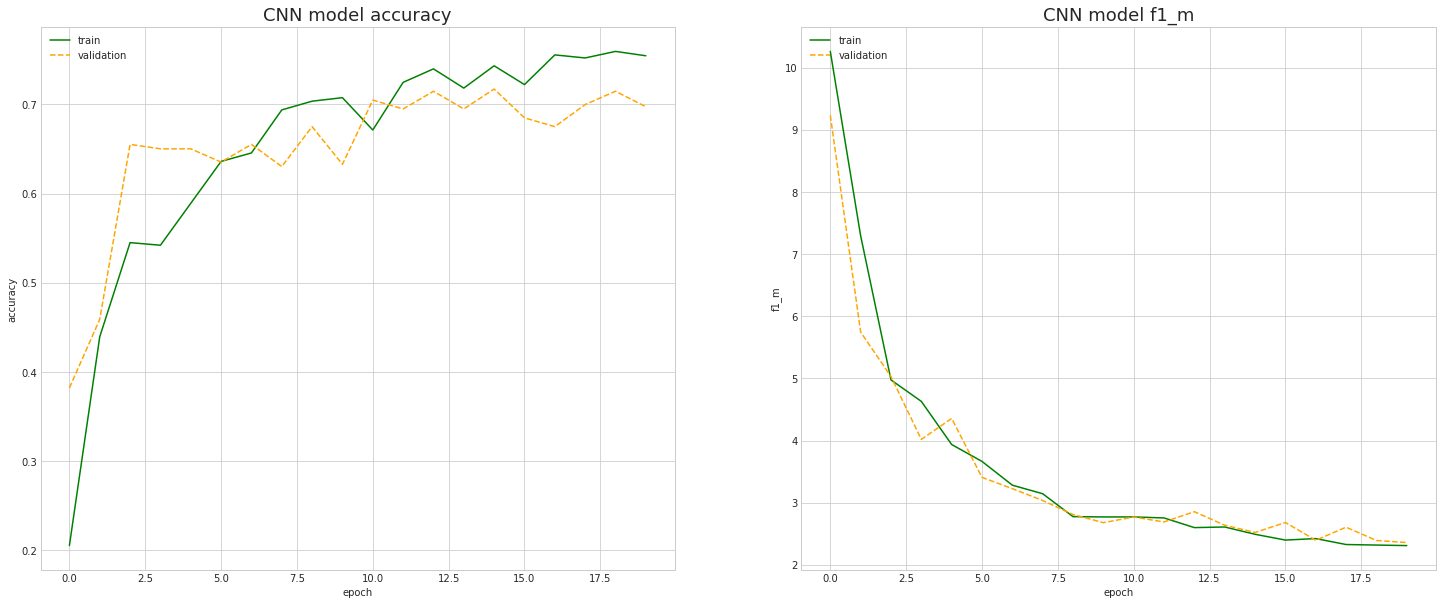

In [45]:
plot_history_scores(
    dict_history = history_resnet, 
    first_score = "accuracy", 
    second_score = "f1_m")

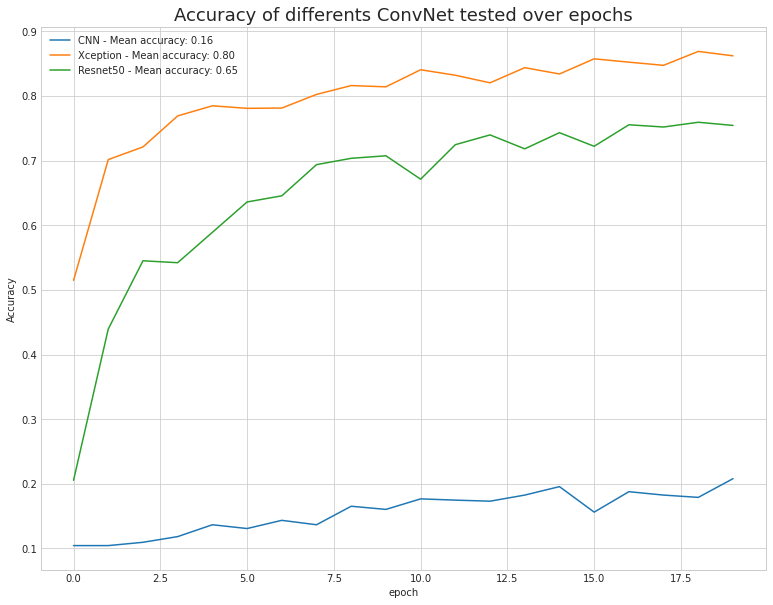

In [46]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(13,10))
    plt.plot(history.history['accuracy'],
             label='CNN - Mean accuracy: {:.2f}'.format(
                 np.mean(history.history['accuracy'])))
    plt.plot(history_xcept.history['accuracy'],
             label='Xception - Mean accuracy: {:.2f}'.format(
                 np.mean(history_xcept.history['accuracy'])))
    plt.plot(history_resnet.history['accuracy'],
             label='Resnet50 - Mean accuracy: {:.2f}'.format(
                 np.mean(history_resnet.history['accuracy'])))
    plt.title('Accuracy of differents ConvNet tested over epochs',
              fontsize=18)
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

At this stage, without parameter tuning or fine-tuning, the Xception model provides the best results. We will therefore keep this model for the next steps.

### 3.4. Hyperparameter Optimization on the Classifier Layer of the Xception Model
Here, we will use kerastuner to optimize the parameters of the classifier layer we added to the Keras Xception model and select the best ones.

In [47]:
def model_builder(hp):
    # Load base model
    xception_model = tf.keras.applications.xception.Xception(
        weights='imagenet',
        include_top=False,
        pooling='avg',
        input_shape=(299,299,3))
    
    for layer in xception_model.layers:
        layer.trainable = False
    
    base_output = xception_model.output
    
    # Tune dense units
    hp_units = hp.Int('dense_units',
                      min_value=32,
                      max_value=300,
                      step=32,
                      default=128)

    base_output = Dense(units=hp_units, 
                        activation='relu')(base_output)
    
    base_output = Dropout(0.2)(base_output)
    
    # Output : new classifier
    predictions = Dense(num_breeds, activation='softmax')(base_output)

    # Define new model
    my_xcept_model = Model(inputs=xception_model.input,
                       outputs=predictions)
    
    # Tune learning rate
    hp_learning_rate = hp.Choice(
        name='learning_rate',
        values=[1e-2, 1e-3, 1e-4])

    my_xcept_model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy", f1_m])
    
    return my_xcept_model

In [48]:
# Tune the learning rate for the optimizer
# Constuct the tuner of kerastuner
tuner = kt.RandomSearch(
    model_builder, 
    objective='val_accuracy',
    max_trials=5)

# Define a early stopping
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5)

# Search best params
tuner.search(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'),
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    epochs=10,
    callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print("-" * 50)
print("Xception Hyperparameters optimization :")
print("-" * 50)
print(f"""
Best learning rate : {best_hps.get('learning_rate')}.\n
Best Dense units : {best_hps.get('dense_units')}.""")

Trial 1 Complete [00h 06m 03s]
val_accuracy: 0.8064516186714172

Best val_accuracy So Far: 0.8064516186714172
Total elapsed time: 00h 06m 03s

Search: Running Trial #2

Hyperparameter    |Value             |Best Value So Far 
dense_units       |256               |192               
learning_rate     |0.001             |0.001             

Epoch 1/10
101/101 [==============================] - 38s 358ms/step - loss: 1.8251 - accuracy: 0.4321 - f1_m: 7.5044 - val_loss: 0.7958 - val_accuracy: 0.7469 - val_f1_m: 2.7065
Epoch 2/10
101/101 [==============================] - 36s 353ms/step - loss: 0.8004 - accuracy: 0.7324 - f1_m: 2.4588 - val_loss: 0.7332 - val_accuracy: 0.7692 - val_f1_m: 2.2467
Epoch 3/10
 14/101 [===>..........................] - ETA: 24s - loss: 0.6795 - accuracy: 0.7860 - f1_m: 2.0821

KeyboardInterrupt: 

Once the best hyperparameters are found, we can retrain the model using the tuner for 30 epochs before saving it for further improvements (fine-tuning):

In [ ]:
hypermodel = tuner.hypermodel.build(best_hps)
hypermodel.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='training'), 
    epochs=30,
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        subset='validation'),
    verbose=2)
hypermodel.save('xception_hypermodel.h5')
print("Model saved")

### 4. Xception Fine Tuning
As seen in the Xception architecture diagram, this model consists of three flows: the entry flow, the middle flow, and the exit flow.
We will fine-tune the last block of the model using the previously saved model whose parameters have been optimized.



In [ ]:
def xception_fine_tune(nb_layers):
    # Load the pre trained model
    hypermodel_t = load_model('./xception_hypermodel.h5', custom_objects={"f1_m": f1_m})
    
    # re train the last layers
    for i, layer in enumerate(hypermodel_t.layers):
        if i < nb_layers:
            layer.trainable = False
        else:
            layer.trainable = True
            
    # Compile model
    hypermodel_t.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy", f1_m])
    
    return hypermodel_t

In [ ]:
# Define a early stopping
stop_early = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    patience=5)

# Dont train the 115 first layers
my_tuned_xcept_model = xception_fine_tune(115)
fine_tuned_history = my_tuned_xcept_model.fit(
    train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        shuffle=False,
        subset='training'), 
    epochs=20,
    validation_data=train_datagen.flow(
        x_train, y_train,
        batch_size=16,
        shuffle=False,
        subset='validation'),
    callbacks=[stop_early],
    verbose=2)

In [ ]:
plot_history_scores(
    dict_history = fine_tuned_history, 
    first_score = "accuracy", 
    second_score = "f1_m")

In [ ]:
with plt.style.context('seaborn-whitegrid'):
    plt.figure(figsize=(13,10))
    plt.plot(history.history['accuracy'],
             label='CNN - Mean accuracy: {:.2f}'.format(
                 np.mean(history.history['accuracy'])))
    plt.plot(history_xcept.history['accuracy'],
             label='Xception - Mean accuracy: {:.2f}'.format(
                 np.mean(history_xcept.history['accuracy'])))
    plt.plot(history_resnet.history['accuracy'],
             label='Resnet50 - Mean accuracy: {:.2f}'.format(
                 np.mean(history_resnet.history['accuracy'])))
    plt.plot(fine_tuned_history.history['accuracy'],
             label='Fine-tuned Xception - Mean accuracy: {:.2f}'.format(
                 np.mean(fine_tuned_history.history['accuracy'])))
    plt.title('Accuracy of differents ConvNet tested over epochs',
              fontsize=18)
    plt.ylabel('Accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

We can see here that the best tested model is the pre-trained Xception model with fine-tuning. We will therefore perform the evaluations on our test data.

### 5. Evaluation of Fine-tuned Xception on Test Data</span>
We will evaluate this final model on the test data generated using the Keras ImageDataGenerator defined previously:



In [ ]:
# Model evaluation on test set
xception_eval = fine_tuned_history.model.evaluate(
    test_datagen.flow(
        x_test, y_test,
        batch_size=16,
        shuffle=False),
    verbose=1)
print("-" * 50)
print("Xception model evaluation :")
print("-" * 50)
print('Test Loss: {:.3f}'.format(xception_eval[0]))
print('Test Accuracy: {:.3f}'.format(xception_eval[1]))
print('Test F1 score: {:.3f}'.format(xception_eval[2]))

In [ ]:
# Make predictions
Y_pred = fine_tuned_history.model.predict(
    test_datagen.flow(
        x_test, y_test,
        batch_size=16,
        shuffle=False))
y_pred = np.argmax(Y_pred, axis=1)

# Inverse transform of encoding
y_pred_s = encoder.inverse_transform(y_pred)
y_test_s = encoder.inverse_transform(y_test)

# Confusion Matrix
cf_matrix = confusion_matrix(y_test, y_pred)

fig = plt.figure(figsize=(12,10))
ax = sns.heatmap(cf_matrix, annot=True)
ax.set_xlabel("Predicted labels", color="g")
ax.set_ylabel("True labels", color="orange")
ax.xaxis.set_ticklabels(encoder.classes_, 
                        rotation='vertical')
ax.yaxis.set_ticklabels(encoder.classes_,
                        rotation='horizontal')
plt.title("Confusion Matrix on Xception predicted results\n",
          fontsize=18)
plt.show()

In [ ]:
# Classification report
print(classification_report(
    y_test, y_pred, 
    target_names=sorted(set(y_test_s))))

In [ ]:
fig = plt.figure(1, figsize=(20,20))
fig.patch.set_facecolor('#343434')
plt.suptitle("Predicted VS actual for Xception model fine-tuned",
             y=.92, fontsize=22,
             color="white")

n = 0

for i in range(12):
    n+=1
    r = int(np.random.randint(0, x_test.shape[0], 1))
    plt.subplot(3,4,n)
    plt.subplots_adjust(hspace = 0.1, wspace = 0.1)
    plt.imshow(image.array_to_img(x_test[r]))
    plt.title('Actual = {}\nPredicted = {}'.format(y_test_s[r] , y_pred_s[r]),
              color="white")
    plt.xticks([]) , plt.yticks([])
    
plt.show()



# <span style="color:#343434" id="section_6">6. Prediction Interface for New Data</span>
Now, we are going to develop a script to enable dog breed prediction from a photo. Our pre-trained model will serve as the basis. For this, we will use Gradio to upload the images (inputs) and apply our classifier to return the prediction.

In [ ]:
# Save the last model
fine_tuned_history.model.save('xception_trained_model.h5')
print("Last model saved")

In [ ]:
# Load model
model = load_model('./xception_hypermodel.h5', custom_objects={"f1_m": f1_m})

# Define the full prediction function
def breed_prediction(inp):
    # Convert to RGB
    img = cv.cvtColor(inp,cv.COLOR_BGR2RGB)
    # Resize image
    dim = (299, 299)
    img = cv.resize(img, dim, interpolation=cv.INTER_LINEAR)
    # Equalization
    img_yuv = cv.cvtColor(img,cv.COLOR_BGR2YUV)
    img_yuv[:,:,0] = cv.equalizeHist(img_yuv[:,:,0])
    img_equ = cv.cvtColor(img_yuv, cv.COLOR_YUV2RGB)
    # Apply non-local means filter on test img
    dst_img = cv.fastNlMeansDenoisingColored(
        src=img_equ,
        dst=None,
        h=10,
        hColor=10,
        templateWindowSize=7,
        searchWindowSize=21)

    # Convert modified img to array
    img_array = keras.preprocessing.image.img_to_array(dst_img)
    
    # Apply preprocess Xception
    img_array = img_array.reshape((-1, 299, 299, 3))
    img_array = tf.keras.applications.xception.preprocess_input(img_array)
    
    # Predictions
    prediction = model.predict(img_array).flatten()
    
    #return prediction
    return {encoder.classes_[i]: float(prediction[i]) for i in range(num_breeds)}

# Construct the interface
image = gr.inputs.Image(shape=(299,299))
label = gr.outputs.Label(num_top_classes=3)

gr.Interface(
    fn=breed_prediction,
    inputs=image,
    outputs=label,
    capture_session=True
).launch(share=True)

In [ ]:
from IPython.display import IFrame
IFrame('https://dogs-breeds-detection-cnn.herokuapp.com/', width=1000, height=900)